<table>
<tr><td><img style="height: 150px;" src="images/geo_hydro1.jpg"></td>
<td bgcolor="#FFFFFF">
    <p style="font-size: xx-large; font-weight: 900; line-height: 100%">AG Dynamics of the Earth</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Juypter notebooks</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Georg Kaufmann</p>
    </td>
</tr>
</table>

# Chemical modelling: Dissociation of water
----
*Georg Kaufmann,
Geophysics Section,
Institute of Geological Sciences,
Freie Universität Berlin,
Germany*

In this notebook, we discuss the **dissociation of water**.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import geodyn_div;geodyn_div.change_fonts()

In [2]:
R        = 8.314   # Gas constant, Pa m3 / K / mol
atm2Pa   = 101325. # 1 atm = 101325 Pa
liter2m3 = 1.e-3   # 1 l   = 1000 cm3 = 10^-3 m3 
year2sec = 365*24*60*60
day2sec  = 24*60*60
min2sec  = 60
tiny     = 1e-20

## Dissociation of water
<img src="images/scheme_purewater.jpg" style="height:50mm">
          
The dissociation of water can be described by the following reaction:
$$
\mbox{H}_2\mbox{O} \overset{k_d}{\underset{k_a}{\leftrightarrow}} \mbox{H}^{+} + \mbox{OH}^{-}
$$
Here, $k_d$ and $k_a$ are the **forward** and **backward** rate constants. Today, this should be reformulated to
$
2\mbox{H}_2\mbox{O} \overset{k_d}{\underset{k_a}{\leftrightarrow}} \mbox{H}_3\mbox{O}^{+} + \mbox{OH}^{-}$ ...

### Forward and backward rate constants $k_d$ and $k_a$
For the forward reaction rate, we find
$$
-\frac{d(\mbox{H}_2\mbox{O})}{dt} = k_d (\mbox{H}_2\mbox{O})
$$
Note that quantities in curly brackets are activities!

This reaction is a reaction of 1th order, but often the activity of water, ($H_2O$), is set to one,
and then the reaction rate reduces to 0th order, and the unit of $k_d$ is: [mol/l/s].

The backward reaction rate is
$$
-\frac{d(\mbox{H}^{+})}{dt} = -\frac{d(\mbox{OH}^{-})}{dt} = k_a (\mbox{H}^{+})(\mbox{OH}^{-})
$$
This is a reaction of 2nd order, thus the unit of $k_a$ is [l/mol/s].

### Equilibrium constant $K_W$ 
Because the forward and backward reactions occur at almost the same speed, the dissociation 
of water is in **equilibrium**, and we can summarize the forward and backward rate constants 
to an **equilibrium constant**:
$$
K_W = \frac{k_d}{k_a}
$$
and the reaction in equilibrium can be written as:
$$
\mbox{H}_2\mbox{O} \stackrel{K_W}{\leftrightarrow} \mbox{H}^{+} + \mbox{OH}^{-}
$$

- A fitted curve for $K_W$ can be found in **Millero et al. (1979). Geochim. Cosmochim. Acta, 43, 1651-1661**.

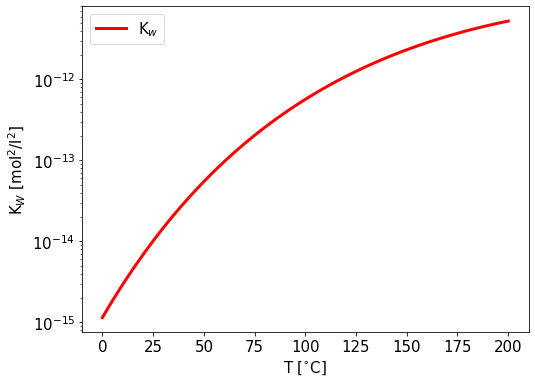

In [3]:
def KW(TC):
    """
    -----------------------------------------------------------------------
    KW - equilibrium constant dissociation of water
    KW: H2O <-> H+ + OH- 
    from:
    Millero, Geochemica et Cosmochemica Acta 43:1651-1661, 1979
    refit data of Harned and Owen, The Physical Chemistry of
    Electrolyte Solutions, 1958
    this is on the SWS pH scale in (mol/kg-SW)^2
    input: 
    TC [C]:         temperature
    output:
    KW [mol^2/l^2]: H2O <-> H+ + OH- 
    -----------------------------------------------------------------------
    """
    TK = 273.16 + TC
    KW = 148.9802 - 13847.26/TK - 23.6521*np.log(TK)
    KW = np.exp(KW)
    return KW

TC = np.linspace(0,200,101)

plt.figure(figsize=(8,6))
plt.xlabel('T [$^{\circ}$C]')
plt.ylabel('K$_W$ [mol$^2$/l$^2$]')
plt.semilogy(TC,KW(TC),linewidth=3,color='red',label='K$_w$')
plt.legend()
plt.savefig('figures/CHEM_KW.png')

Get rate constants $k_d$ and $k_a$ from equilibrium constant $K_w$:
- A value for $k_a$ is quoted in **Stillinger (1978). Theoretical chemistry, Academic Press**, who quotes **Eigen &De Maeyer, L. (1958). Proc. R. Soc. (London) Ser. A 247, 505-533**.<br>
$$k_a(25^{\circ}C) = (1.4 \pm 0.2) \times 10^{11} \mbox{ l/mol/s}$$
- $k_d$ can then be calculated, $k_d=k_a K_W$.

In [4]:
TC = 25.
ka = 1.4e11 # l/mol/s
kd = ka*KW(TC)
print(TC,KW(TC),kd,ka)

25.0 1.0131768731658128e-14 0.001418447622432138 140000000000.0


## From chemical reaction to differential equation
Both the activities of hydrogen H$^+$ and hydroxyl OH$^-$ change
through dissociation (forward reactions, increase), and
association (backward reaction, decrease):
$$
\begin{array}{rcl}
\frac{d(\mbox{H}^{+})}{dt} &=& k_d (\mbox{H}_2\mbox{O}) - k_a (\mbox{H}^+) (\mbox{OH}^-) \\
\frac{d(\mbox{OH}^{-})}{dt} &=& k_d (\mbox{H}_2\mbox{O}) - k_a (\mbox{H}^+) (\mbox{OH}^-) \\
\end{array}
$$

This coupled set of ordinary differential equations is now
solved with the `odeint` package from `scipy`. Steps:
- Define right-hand side as function `rhs`
- Set initial conditions
- Solve system

In [5]:
def rhs(y,t,kd,ka):
    """
    right-hand side of system of diff. equations
    input: old values y^(i-1)
    y[0] - H+
    y[1] - OH-
    output: right-hand sides
    dydt[0] - dH+/dt
    dydt[1] - dCOH-/dt
    """
    dHp  = kd*1 - ka*y[0]*y[1]
    dOHm = kd*1 - ka*y[0]*y[1]
    dydt = [dHp,dOHm]
    return dydt

In [6]:
t = np.linspace(0,0.0005,50000)
Hp0  = 0.
OHm0 = 0.
y0   = [Hp0,OHm0]
print(y0)
sol = scipy.integrate.odeint(rhs, y0, t, args=(kd,ka))

[0.0, 0.0]


In [7]:
print(sol)

[[0.00000000e+00 0.00000000e+00]
 [1.41847597e-11 1.41847597e-11]
 [2.83695189e-11 2.83695189e-11]
 ...
 [1.00758261e-07 1.00758261e-07]
 [1.00758262e-07 1.00758262e-07]
 [1.00758263e-07 1.00758263e-07]]


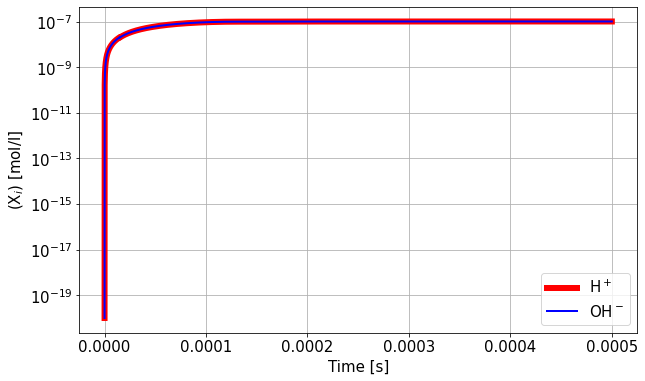

In [8]:
plt.figure(figsize=(10,6))
plt.xlabel('Time [s]')
plt.ylabel('(X$_i$) [mol/l]')
plt.semilogy(t,sol[:,0]+tiny,linewidth=6,color='red',label='H$^+$')
plt.semilogy(t,sol[:,1]+tiny,linewidth=2,color='blue',label='OH$^-$')
plt.grid()
plt.legend()

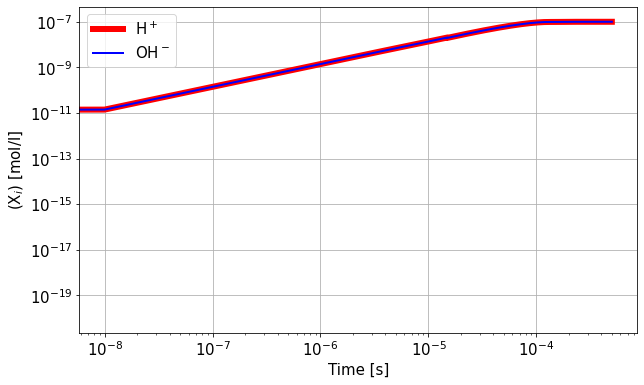

In [9]:
plt.figure(figsize=(10,6))
plt.xlabel('Time [s]')
plt.ylabel('(X$_i$) [mol/l]')
plt.loglog(t,sol[:,0]+tiny,linewidth=6,color='red',label='H$^+$')
plt.loglog(t,sol[:,1]+tiny,linewidth=2,color='blue',label='OH$^-$')
plt.grid()
plt.legend()

----
## pH
The pH value is defined as:
$$
\mbox{pH} = - \log(\mbox{H}^+)
$$

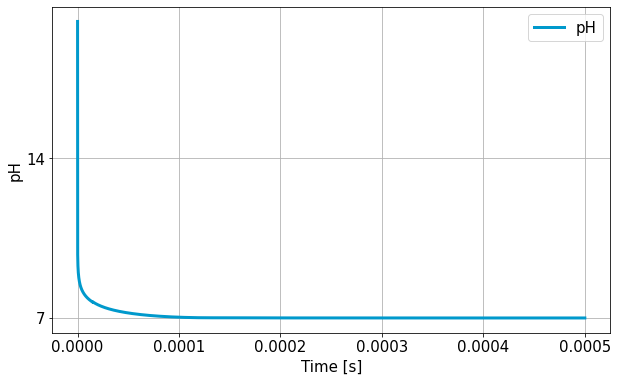

In [10]:
plt.figure(figsize=(10,6))
plt.xlabel('Time [s]')
plt.ylabel('pH')
plt.yticks([7,14])
plt.plot(t,-np.log10(sol[:,0]+tiny),linewidth=3,color=(0,0.6,0.8),label='pH')
plt.grid()
plt.legend()

In [11]:
!-----------------------------------------------------------------------
!  function calculates mass balance coefficients K1,K2,KC,KH
! input:
!  tempc               - C
! output:
!  K1                  - mol / l
!  K2                  - mol / l
!  KC                  - mol^2 / l^2
!  KH                  - mol / l atm
!  version from original publications
!  written by Georg Kaufmann 03/01/2008
!-----------------------------------------------------------------------
implicit none
integer,  parameter                   :: id = kind(0.0d0)
real(id)                              :: tempc,tempa
real(id)                              :: k0,k1,k2,k3,k4,k5,k6,k7,k8,kc,ka,kh,kw
!-----------------------------------------------------------------------
! change temperature to absolute temperature and calculate coefficient
!-----------------------------------------------------------------------
tempa  = 273.16d0 + tempc
k2     = 10.d0**(-107.8871 + 5151.79 / tempa - 0.03252849 * tempa        
       + 38.92561 * dlog10(tempa) - 563713.9 / tempa / tempa)
k3     = 10.d0**(1209.12 - 34765.05 / tempa + 0.31294 * tempa            
       - 478.782 * dlog10(tempa))
k4     = 10.d0**(-1228.732 + 35512.75 / tempa                         
       - 0.299444 * tempa + 485.818 * dlog10(tempa))
k5     = 1.707d-4
k6     = 10.d0**(-356.3094 + 21834.37 / tempa - 0.060919964 * tempa      
       + 126.8339 * dlog10(tempa) - 1684915 / tempa / tempa)
k7     = 10.d0**(-2.201d0 - 6.6d-3*tempc)
k8     = 10.d0**(-1.299d0 - 2.9d-3*tempc)
k1     = 10.d0**(-356.3094 - 0.06091964 * tempa + 21834.37 / tempa       
       + 126.8339 * dlog10(tempa) - 1684915. / tempa / tempa)
k0     = k5 / k1
kh     = 10.d0**(108.3865 - 6919.53 / tempa + 0.01985076 * tempa         
       - 40.45154 * dlog10(tempa) + 669365. / tempa / tempa)
kw     = 10.e0**(22.801 - 4787.3 / tempa - 0.010365 * tempa              
       - 7.1321 * dlog10(tempa))
kc     = 10.d0**(-171.9065 - 0.077993 * tempa + 2839.319 / tempa         
       + 71.595 * dlog10(tempa))
ka     = 0.d0 ! not defined in this subroutine

SyntaxError: invalid syntax (3557741951.py, line 13)

In [ ]:
def k0k1k2k5(TC):
    """
    !-----------------------------------------------------------------------
    ! K_1 and K_2
    !-----------------------------------------------------------------------
    ! pure water
    ! Millero, F. J., Geochemica et Cosmochemica Acta 43:1651-1661, 1979:
    ! K1 from refit data from Harned and Davis,
    ! J American Chemical Society, 65:2030-2037, 1943.
    ! K2 from refit data from Harned and Scholes,
    ! J American Chemical Society, 43:1706-1709, 1941.
    ! This is only to be used for Sal=0 water (note the absence of S in the below formulations)
    ! These are the thermodynamic Constants:
    ! this is on the SWS pH scale in mol/kg-SW
    """
    TK       = 273.16 + TC
    k1 = 290.9097 - 14554.21/TK - 45.0575*np.log(TK)
    k1 = np.exp(k1)
    k2 = 207.6548 - 11843.79/TK - 33.6485*np.log(TK)
    k2 = np.exp(k2)
    k5 = 1.707e-4
    k0 = k5 / k1
    return k0,k1,k2,k5

----
## Literature

----